# **Preparación entorno**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install wandb --quiet

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall
import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# **División dataset**

In [ ]:
# Cargamos valid y test
valid_df = pd.read_csv('/content/drive/MyDrive/TFM/splits/valid_split_bien.csv')
test_df = pd.read_csv('/content/drive/MyDrive/TFM/splits/test_split_bien.csv')

In [ ]:
# Cargamos train para el dataset de 600 muestras por clase
train_df_600 = pd.read_csv('/content/drive/MyDrive/TFM/data/train_df_600.csv')
# Convertimos a string para que los generadores
train_df_600["filepath"] = train_df_600["filepath"].astype(str)
train_df_600["label"] = train_df_600["label"].astype(str)

In [ ]:
# Cargamos los dataset aumentados artificialmente
def load_augmented_train_df(augmented_dir):
    filepaths = []
    labels = []

    for label in ['0', '1']:
        label_dir = os.path.join(augmented_dir, label)
        for fname in os.listdir(label_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(label_dir, fname))
                labels.append(label)

    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

In [ ]:
train_df_1000 = load_augmented_train_df('/content/drive/MyDrive/TFM/data/augmented_train_1000')
train_df_2000 = load_augmented_train_df('/content/drive/MyDrive/TFM/data/augmented_train_2000')
train_df_3000 = load_augmented_train_df('/content/drive/MyDrive/TFM/data/augmented_train_3000')

In [ ]:
# Generadores base
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

# Parámetros comunes
img_size = (224, 224)
batch_size = 16

valid_df["label"] = valid_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

# Generadores de entrenamiento
train_gen_600 = tr_gen.flow_from_dataframe(train_df_600, x_col='filepath', y_col='label',
                                           class_mode='binary', target_size=img_size, batch_size=batch_size)

train_gen_1000 = tr_gen.flow_from_dataframe(train_df_1000, x_col='filepaths', y_col='labels',
                                            class_mode='binary', target_size=img_size, batch_size=batch_size)

train_gen_2000 = tr_gen.flow_from_dataframe(train_df_2000, x_col='filepaths', y_col='labels',
                                            class_mode='binary', target_size=img_size, batch_size=batch_size)

train_gen_3000 = tr_gen.flow_from_dataframe(train_df_3000, x_col='filepaths', y_col='labels',
                                            class_mode='binary', target_size=img_size, batch_size=batch_size)

# Validación y test
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepath', y_col='label',
                                       class_mode='binary', target_size=img_size, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepath', y_col='label',
                                      class_mode='binary', target_size=img_size, batch_size=batch_size, shuffle=False)

Found 1138 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
Found 187 validated image filenames belonging to 2 classes.
Found 188 validated image filenames belonging to 2 classes.


# **Arquitectura modelo**

In [ ]:
# Creamos la métrica F1Score para evaluar el modelo
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        y_true = tf.cast(tf.reshape(y_true, tf.shape(y_pred)), tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

        self.f1.assign_add(f1)
        self.count.assign_add(1.0)

    def result(self):
        return self.f1 / self.count

    def reset_states(self):
        self.f1.assign(0.0)
        self.count.assign(0.0)

In [ ]:
# Creamos la métrica Specificity para evaluar el modelo
class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name='specificity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tn = self.add_weight(name='true_negatives', initializer='zeros')
        self.fp = self.add_weight(name='false_positives', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Asegura formas compatibles y valores float binarios
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        y_true = tf.cast(tf.reshape(y_true, tf.shape(y_pred)), tf.float32)

        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)

        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.count.assign_add(1.0)

    def result(self):
        specificity = self.tn / (self.tn + self.fp + tf.keras.backend.epsilon())
        return specificity

    def reset_states(self):
        self.tn.assign(0.0)
        self.fp.assign(0.0)
        self.count.assign(0.0)

In [ ]:
def create_mobilenetv2_model():
    # Cargamos MobileNetV2 con pesos de ImageNet, sin incluir las capas superiores
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Congelamos todas las capas
    for layer in base_model.layers:
        layer.trainable = False

    # Descongelar el 30% superior de las capas para fine-tuning parcial
    unfreeze_index = int(np.round((len(base_model.layers) - 1) * 0.7))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True

    # Añadimos capas personalizadas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    # Creamos el modelo final
    model = Model(inputs=base_model.input, outputs=output_layer)
    return model

# Creamos y compilamos el modelo con optimizador RMSprop (recomendado para fine-tuning) y tasa de aprendizaje pequeña
mobilenet_model = create_mobilenetv2_model()
mobilenet_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='F1 score'),
        Specificity(name='specificity')
    ]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobilenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 3,112,385 (11.87 MB)

 Non-trainable params: 458,368 (1.75 MB)

# **Entrenamiento modelo**

In [ ]:
# Creamos una clase para guardar las métricas en Weights & Biases
class WandbLoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            wandb.log(logs, step=epoch)

In [ ]:
wandb.login()

# Diccionario de generadores
train_generators = {
    "600": train_gen_600,
    "1000": train_gen_1000,
    "2000": train_gen_2000,
    "3000": train_gen_3000
}
# Diccionario para guardar las ejecuciones de cada muestra
histories = {}

for name in ["600", "1000", "2000", "3000"]:
    # Iniciamos un nuevo run en wandb para este modelo
    wandb.init(
        project="mamografia clasificacion mobilenet",
        name=f"run_{name}_muestras",
        reinit=True
    )

    print(f"\n Entrenando modelo MobileNetV2 con {name} muestras")

    # Definimos modelcheckpoint y earlystopping como callbacks
    checkpoint_path = f"/content/drive/MyDrive/TFM/models/MobileNetV2/model_best_{name}.weights.h5"

    checkpoint_callback = ModelCheckpoint(
        monitor='val_accuracy',
        mode='max',
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=5,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    callbacks = [
    checkpoint_callback,
    early_stop,
    WandbLoggingCallback()
]

    # Entrenamiento del modelo
    history = mobilenet_model.fit(
        train_generators[name],
        validation_data=valid_gen,
        batch_size=16,
        epochs=30,
        callbacks=callbacks
    )

    histories[name] = history
    wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: elias-pallares (elias-pallares-universitat-pompeu-fabra) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



 Entrenando modelo MobileNetV2 con 600 muestras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - F1 score: 0.5587 - accuracy: 0.5934 - auc: 0.6393 - loss: 0.6942 - precision: 0.6000 - recall: 0.5837 - specificity: 0.6029
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/TFM/models/MobileNetV2/model_best_600.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - F1 score: 0.5598 - accuracy: 0.5943 - auc: 0.6403 - loss: 0.6934 - precision: 0.6009 - recall: 0.5848 - specificity: 0.6037 - val_F1 score: 0.0590 - val_accuracy: 0.5000 - val_auc: 0.6881 - val_loss: 0.7990 - val_precision: 0.5000 - val_recall: 0.0333 - val_specificity: 0.9667
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - F1 score: 0.8206 - accuracy: 0.8328 - auc: 0.9151 - loss: 0.3843 - precision: 0.8155 - recall: 0.8435 - specificity: 0.8230
Epoch 2: val_accuracy improved from 0.50000 to 0.53333, saving model to /content/drive/MyDrive/TFM/models/MobileNetV2/model_best_600.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - F1 s

F1 score,▁▅▆███
accuracy,▁▅▆███
auc,▁▆▇███
loss,█▅▃▁▁▁
precision,▁▄▆███
recall,▁▅▇███
specificity,▁▄▆███
val_F1 score,▂▃█▁▁▄
val_accuracy,▁▄█▂▁▄
val_auc,▇█▅▆▁█
val_loss,▁▁▁▄█▄



 Entrenando modelo MobileNetV2 con 1000 muestras
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - F1 score: 0.6682 - accuracy: 0.7389 - auc: 0.8188 - loss: 0.5161 - precision: 0.7058 - recall: 0.6923 - specificity: 0.7723
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to /content/drive/MyDrive/TFM/models/MobileNetV2/model_best_1000.weights.h5
110/110 ━━━━━━━━━━━━━━━━━━━━ 513s 5s/step - F1 score: 0.6687 - accuracy: 0.7391 - auc: 0.8190 - loss: 0.5159 - precision: 0.7060 - recall: 0.6927 - specificity: 0.7723 - val_F1 score: 0.0204 - val_accuracy: 0.5500 - val_auc: 0.8156 - val_loss: 1.1890 - val_precision: 1.0000 - val_recall: 0.0100 - val_specificity: 1.0000
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - F1 score: 0.8537 - accuracy: 0.8761 - auc: 0.9477 - loss: 0.2995 - precision: 0.8729 - recall: 0.8586 - specificity: 0.8910
Epoch 2: val_accuracy did not improve from 0.55000
110/110 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - F1 score: 0.8537 - accuracy: 0.8761 -

F1 score,▁▅▇█████
accuracy,▁▅▇█████
auc,▁▆▇█████
loss,█▅▃▁▁▁▁▁
precision,▁▅▇█████
recall,▁▅▇█████
specificity,▁▅▇█████
val_F1 score,▁▁▇▂▄▆▃█
val_accuracy,▁▁▇▂▃▅▂█
val_auc,▇▅▇▁▃▅▁█
val_loss,▂▄▁▇▅▃█▂



 Entrenando modelo MobileNetV2 con 2000 muestras
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - F1 score: 0.8684 - accuracy: 0.8715 - auc: 0.9393 - loss: 0.3331 - precision: 0.8710 - recall: 0.8742 - specificity: 0.8688
Epoch 1: val_accuracy improved from -inf to 0.83000, saving model to /content/drive/MyDrive/TFM/models/MobileNetV2/model_best_2000.weights.h5
200/200 ━━━━━━━━━━━━━━━━━━━━ 843s 4s/step - F1 score: 0.8684 - accuracy: 0.8715 - auc: 0.9393 - loss: 0.3331 - precision: 0.8710 - recall: 0.8742 - specificity: 0.8688 - val_F1 score: 0.8185 - val_accuracy: 0.8300 - val_auc: 0.9161 - val_loss: 0.3872 - val_precision: 0.8511 - val_recall: 0.8000 - val_specificity: 0.8600
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - F1 score: 0.9552 - accuracy: 0.9556 - auc: 0.9909 - loss: 0.1230 - precision: 0.9566 - recall: 0.9587 - specificity: 0.9523
Epoch 2: val_accuracy did not improve from 0.83000
200/200 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - F1 score: 0.9552 - accuracy: 0.9555 -

F1 score,▁▆█▇██
accuracy,▁▆▇▇██
auc,▁▇████
loss,█▃▂▂▁▁
precision,▁▆█▇██
recall,▁▆▇███
specificity,▁▆█▇██
val_F1 score,█▇██▃▁
val_accuracy,▇▇▇█▃▁
val_auc,████▄▁
val_loss,▁▁▁▂▅█



 Entrenando modelo MobileNetV2 con 3000 muestras
Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - F1 score: 0.9176 - accuracy: 0.9200 - auc: 0.9765 - loss: 0.1907 - precision: 0.9131 - recall: 0.9319 - specificity: 0.9072
Epoch 1: val_accuracy improved from -inf to 0.81833, saving model to /content/drive/MyDrive/TFM/models/MobileNetV2/model_best_3000.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 1228s 4s/step - F1 score: 0.9176 - accuracy: 0.9200 - auc: 0.9765 - loss: 0.1907 - precision: 0.9131 - recall: 0.9319 - specificity: 0.9072 - val_F1 score: 0.8295 - val_accuracy: 0.8183 - val_auc: 0.9106 - val_loss: 0.6403 - val_precision: 0.7520 - val_recall: 0.9500 - val_specificity: 0.6867
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - F1 score: 0.9657 - accuracy: 0.9674 - auc: 0.9954 - loss: 0.0853 - precision: 0.9631 - recall: 0.9724 - specificity: 0.9623
Epoch 2: val_accuracy improved from 0.81833 to 0.86167, saving model to /content/drive/MyDrive/TFM/models/MobileNetV2/model_best_30

F1 score,▁▆▆▇▇▇▇▇██
accuracy,▁▆▆▇▇▇▇███
auc,▁▇▇▇▇████▇
loss,█▄▃▃▂▂▂▂▁▂
precision,▁▆▆▇▇▇▇▇██
recall,▁▆▆▇▇█▇███
specificity,▁▆▆▇▇▇▇▇██
val_F1 score,▄▅▄▁▇▇▇▇▆█
val_accuracy,▁▄▄▁▇▇▇▆▆█
val_auc,▁▄▅▁█▇▇▆▇▇
val_loss,▄▃▃█▁▂▂▂▂▁


# **Perfomance**

 ## Comparando métricas de entrenamiento y validación

In [ ]:
def plot_training_curves(history, title_prefix='', save_dir='/content/drive/MyDrive/TFM/plots/'):
    # Extraemos los valores de accuracy y loss del entrenamiento y validación
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Encontramos el índice (epoch) con la menor pérdida de validación
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    # Encontramos el índice (epoch) con la mayor accuracy de validación
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    # Creamos una lista con los números de época
    Epochs = [i+1 for i in range(len(tr_acc))]

    # Etiquetas para marcar las mejores epoch en las gráficas
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    # Definimos el tamaño de la figura
    plt.figure(figsize=(20, 8))
    #Gráfico loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title(f'{title_prefix} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #Gráfico accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title(f'{title_prefix} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Ajustamos el diseño para que no se sobrepongan los elementos
    plt.tight_layout()
    # Establecemos ruta de guardado de las figuras en formato png
    os.makedirs(save_dir, exist_ok=True)
    filename = title_prefix.strip().replace(' ', '_').replace('-', '') + ".png"
    filepath = os.path.join(save_dir, f"training_curve_{filename}")
    plt.savefig(filepath)
    print(f" Gráfico guardado en: {filepath}")
    plt.show()

 Gráfico guardado en: /content/drive/MyDrive/TFM/plots/training_curve_MobileNetV2__600_muestras.png


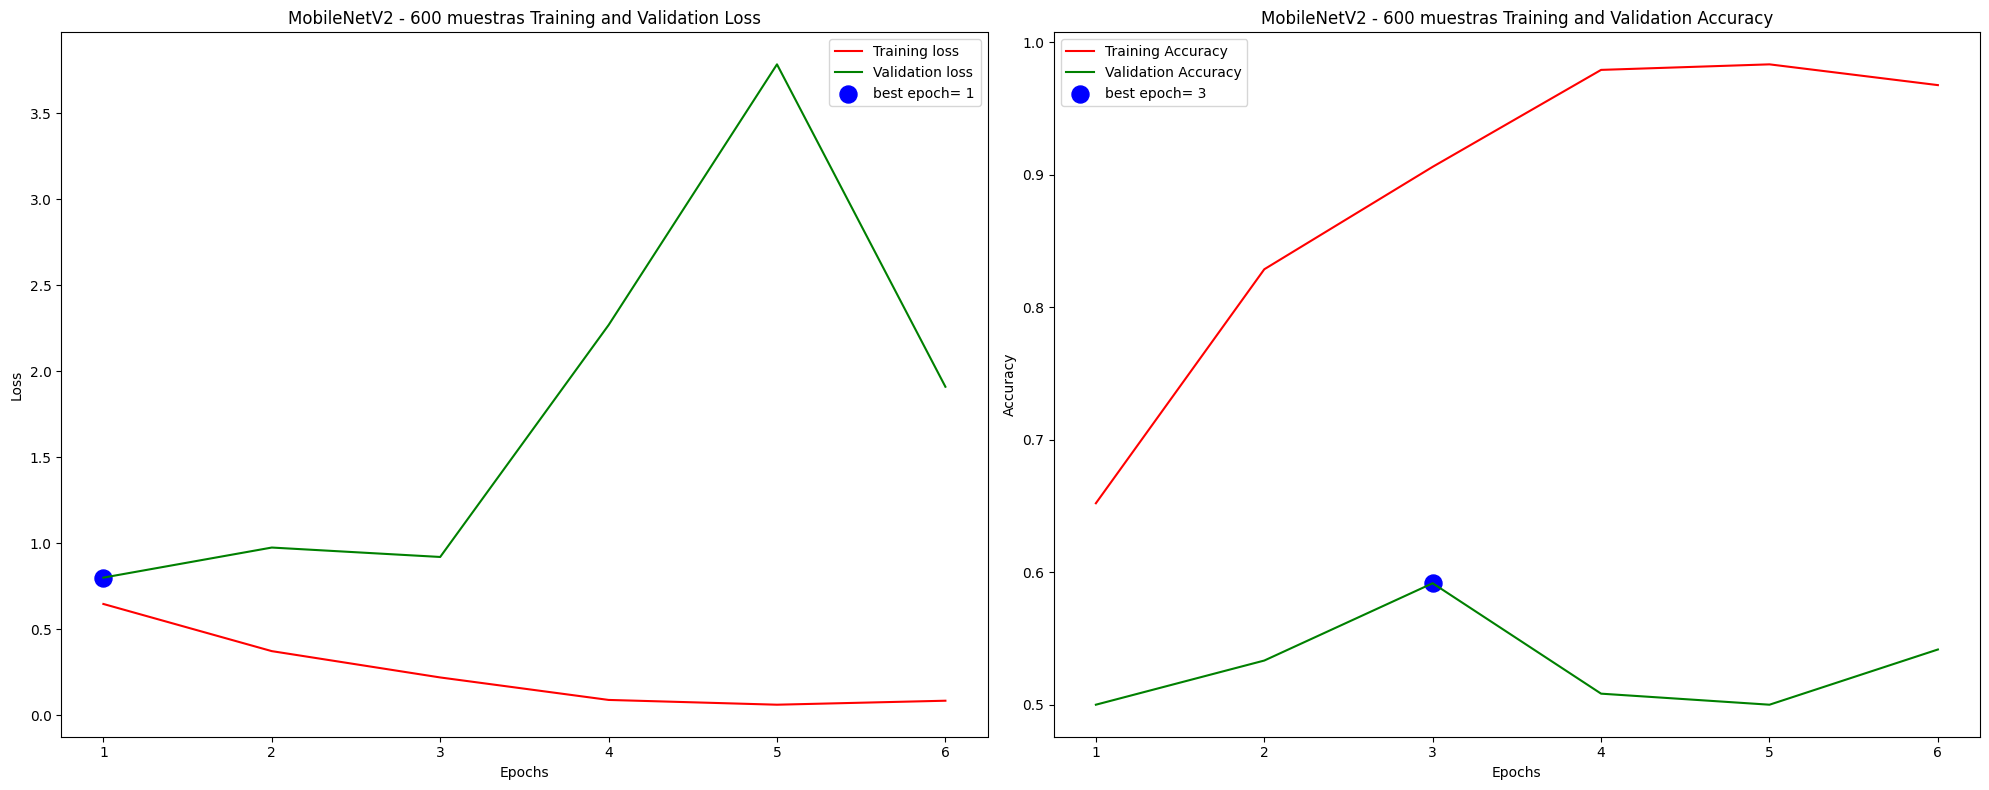

 Gráfico guardado en: /content/drive/MyDrive/TFM/plots/training_curve_MobileNetV2__1000_muestras.png


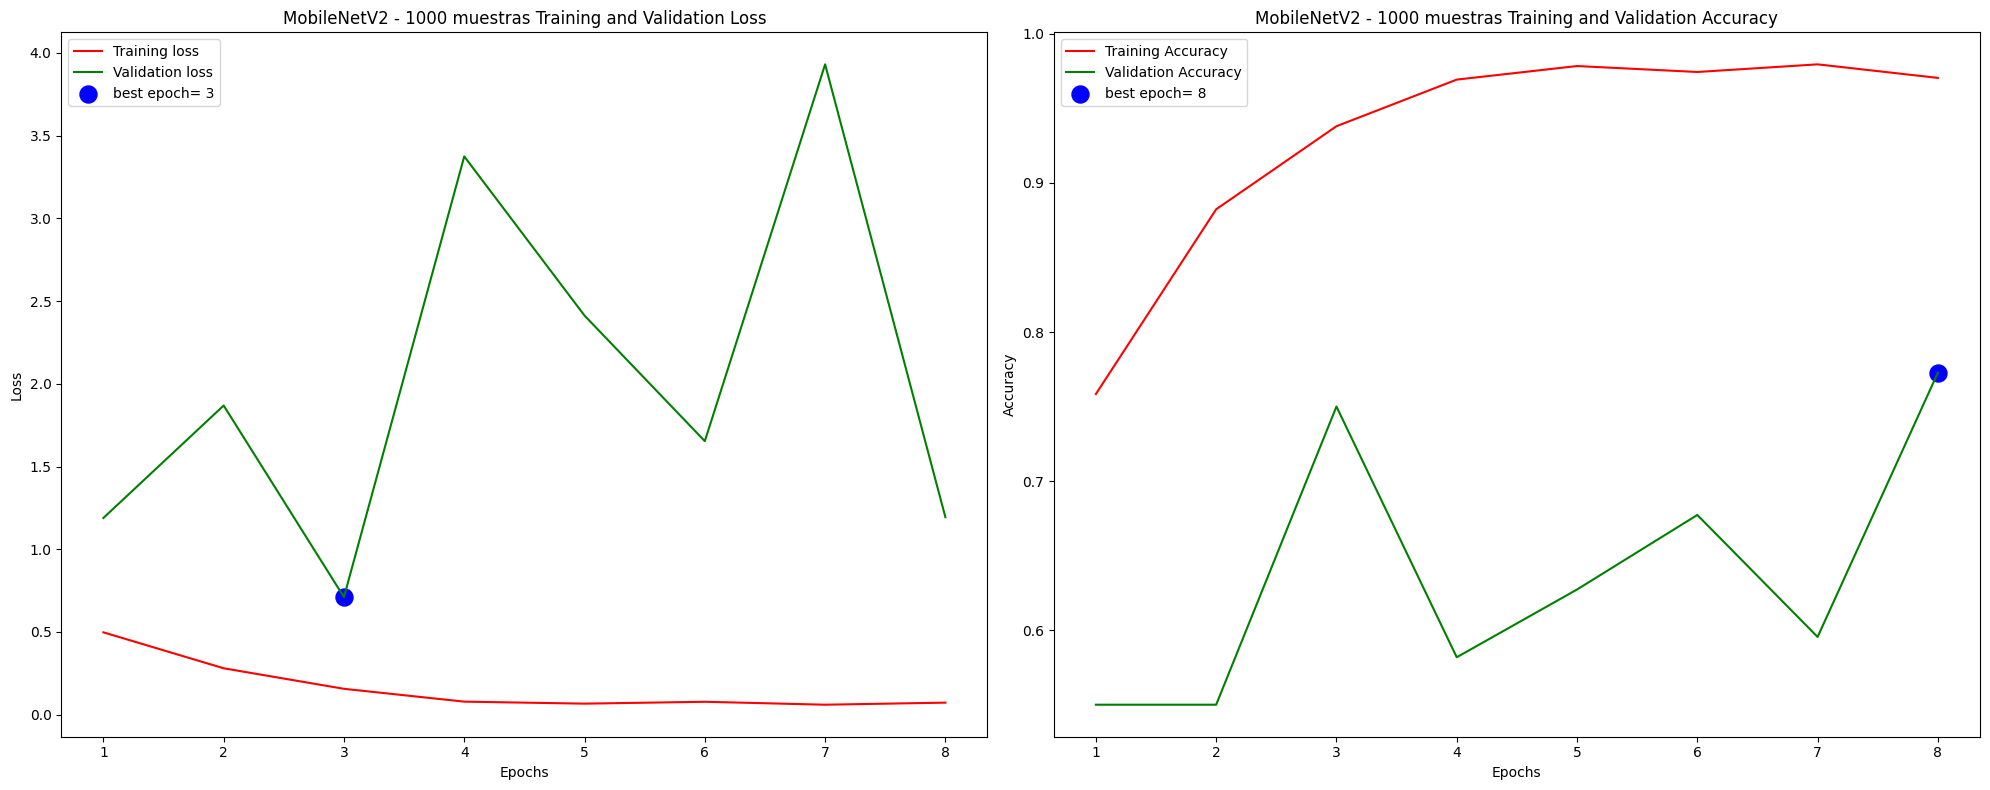

 Gráfico guardado en: /content/drive/MyDrive/TFM/plots/training_curve_MobileNetV2__2000_muestras.png


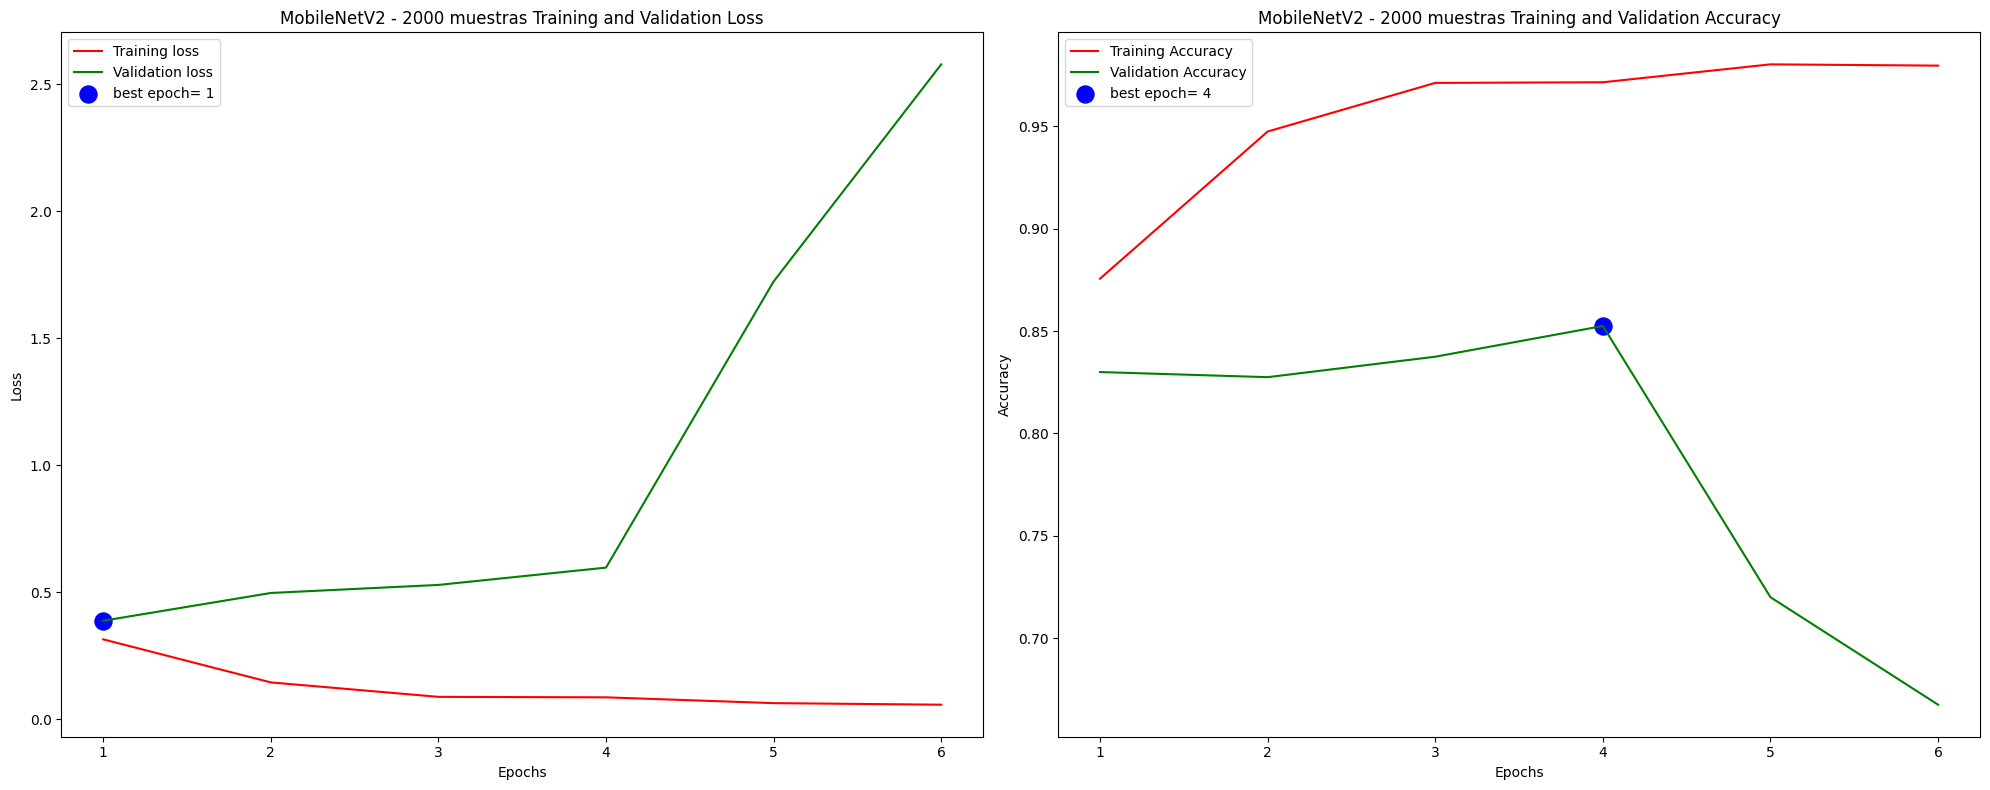

 Gráfico guardado en: /content/drive/MyDrive/TFM/plots/training_curve_MobileNetV2__3000_muestras.png


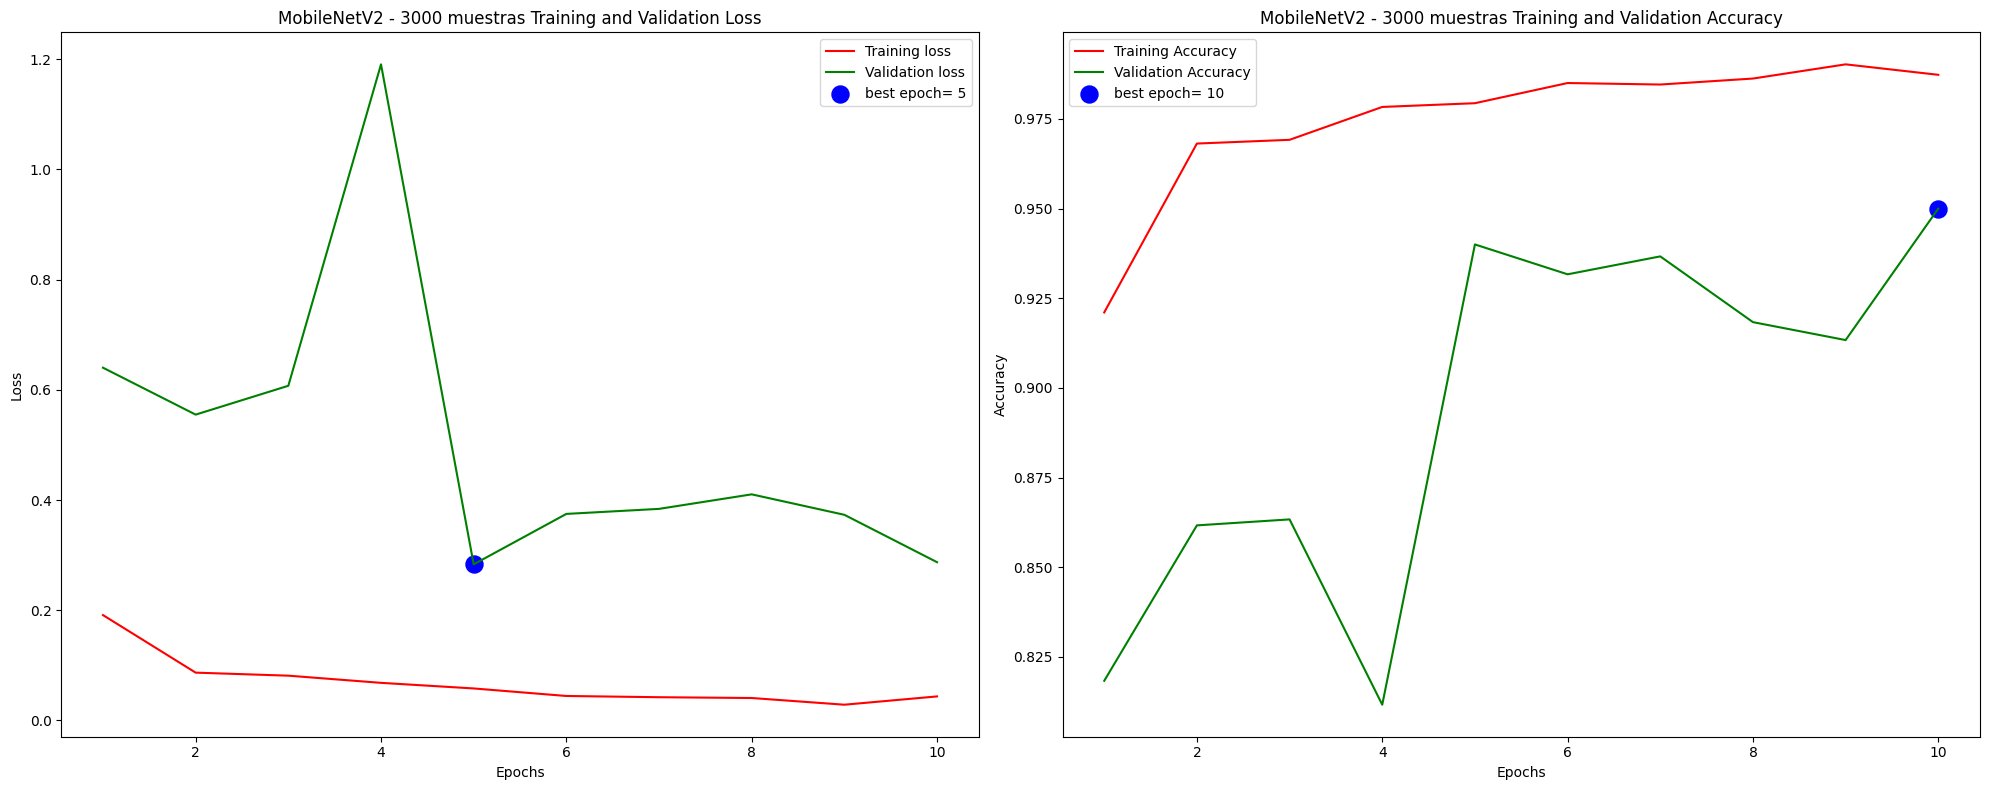

In [ ]:
for name, history in histories.items():
    plot_training_curves(history, title_prefix=f'MobileNetV2 - {name} muestras')

## Evaluación métricas validación

In [ ]:
def plot_metrics(history, title_prefix='', save_dir='/content/drive/MyDrive/TFM/plots/'):
    # Métricas a graficar
    metrics_to_plot = [
        'val_accuracy', 'val_precision', 'val_recall',
        'val_F1 score', 'val_auc', 'val_specificity'
    ]
    metric_names = {
        'val_accuracy': 'Accuracy',
        'val_precision': 'Precision',
        'val_recall': 'Recall',
        'val_F1 score': 'F1-score',
        'val_auc': 'AUC',
        'val_specificity': 'Specificity'
    }

    # Eje x
    epochs = range(1, len(history.history['val_accuracy']) + 1)

    # Creamos figura
    plt.figure(figsize=(22, 10))

    for i, metric in enumerate(metrics_to_plot, 1):
        if metric in history.history:
            values = history.history[metric]
            best_epoch = np.argmax(values)
            best_value = values[best_epoch]

            plt.subplot(2, 3, i)
            plt.plot(epochs, values, label=metric_names[metric], linewidth=2)
            plt.scatter(best_epoch + 1, best_value, s=100, c='red', label=f'Best = {best_value:.4f}')
            plt.title(f'{metric_names[metric]} por epochs', fontsize=14)
            plt.xlabel('Epoch')
            plt.ylabel(metric_names[metric])
            plt.legend()

    plt.suptitle(f'{title_prefix}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Establecemos ruta de guardado de las figuras en formato png
    os.makedirs(save_dir, exist_ok=True)
    filename = title_prefix.strip().replace(' ', '_').replace('-', '') + ".png"
    filepath = os.path.join(save_dir, f"metrics_{filename}")
    plt.savefig(filepath)
    print(f"Gráfico guardado en: {filepath}")

    plt.show()

Gráfico guardado en: /content/drive/MyDrive/TFM/plots/metrics_MobileNetV2__600_muestras.png


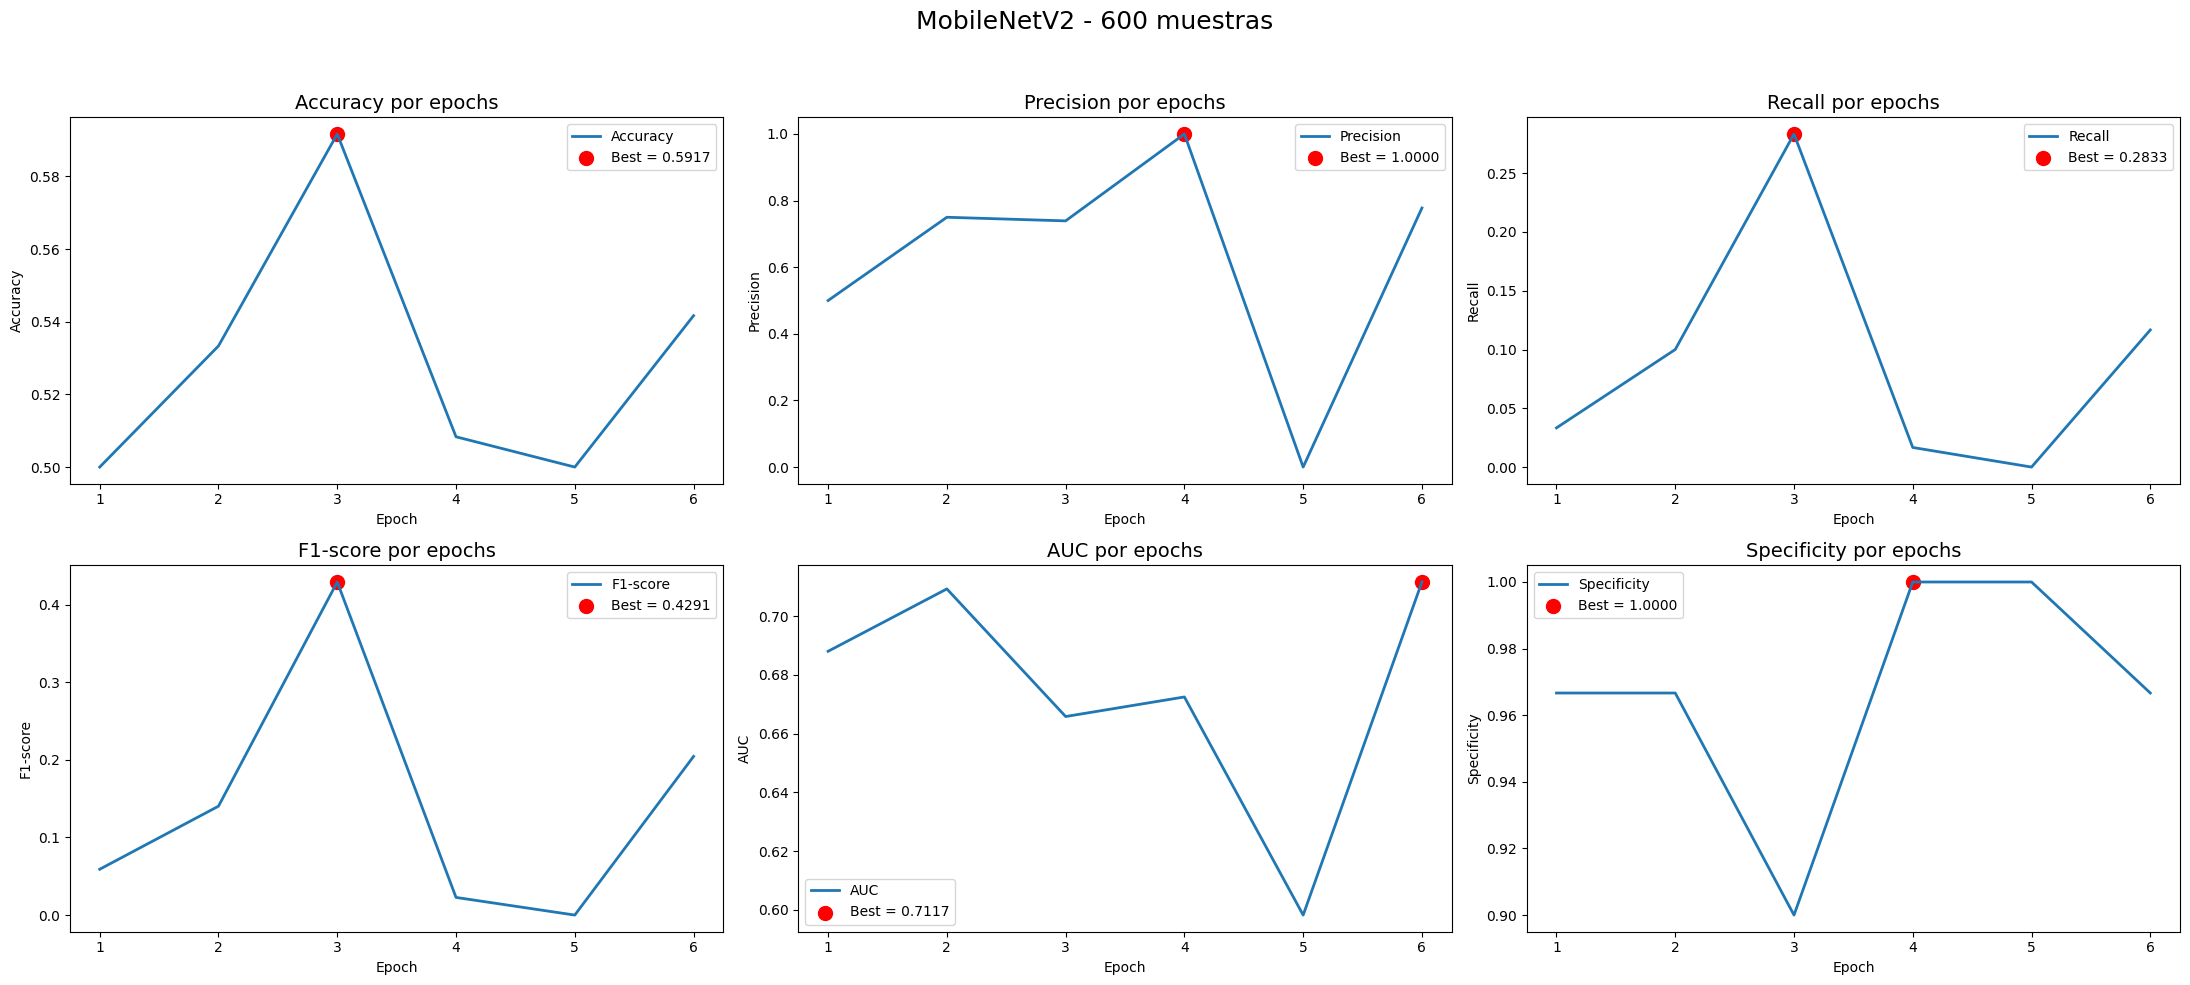

Gráfico guardado en: /content/drive/MyDrive/TFM/plots/metrics_MobileNetV2__1000_muestras.png


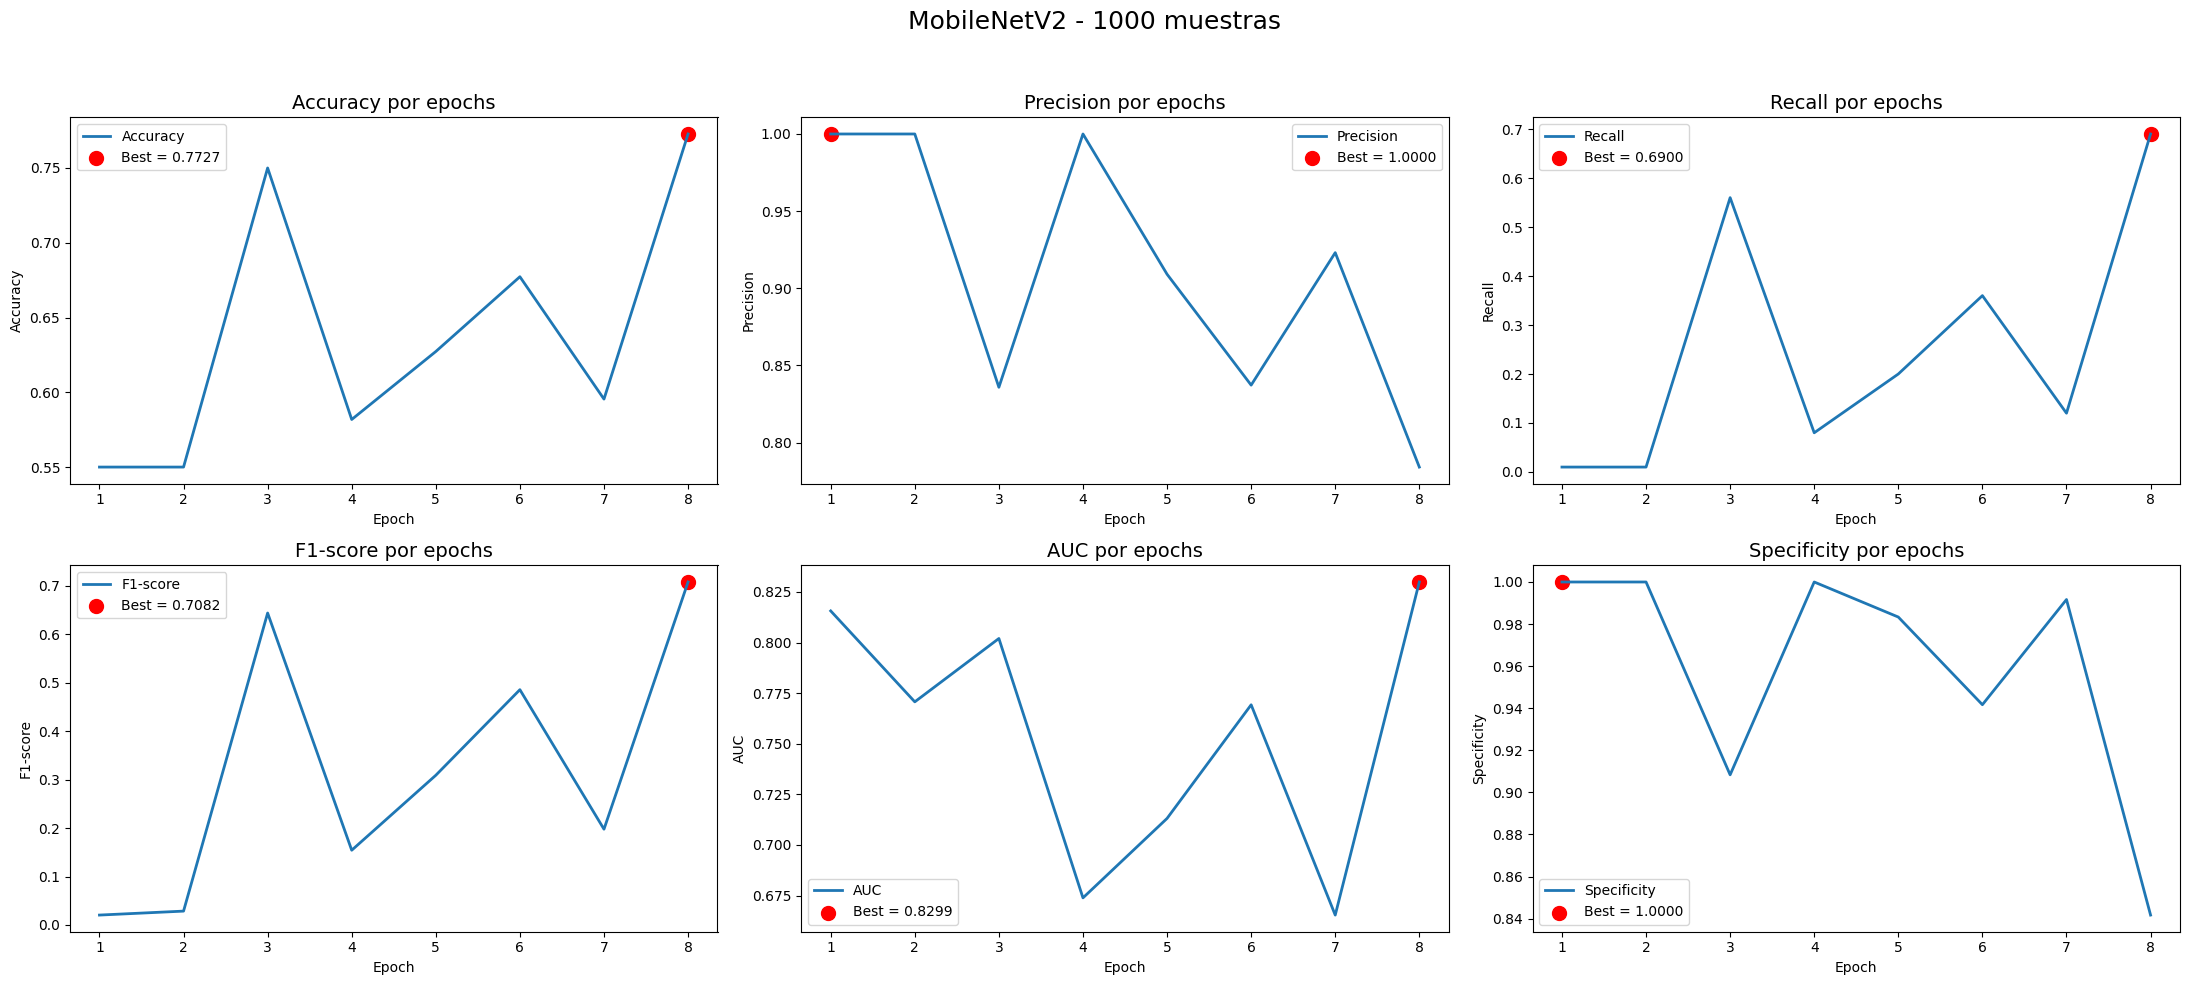

Gráfico guardado en: /content/drive/MyDrive/TFM/plots/metrics_MobileNetV2__2000_muestras.png


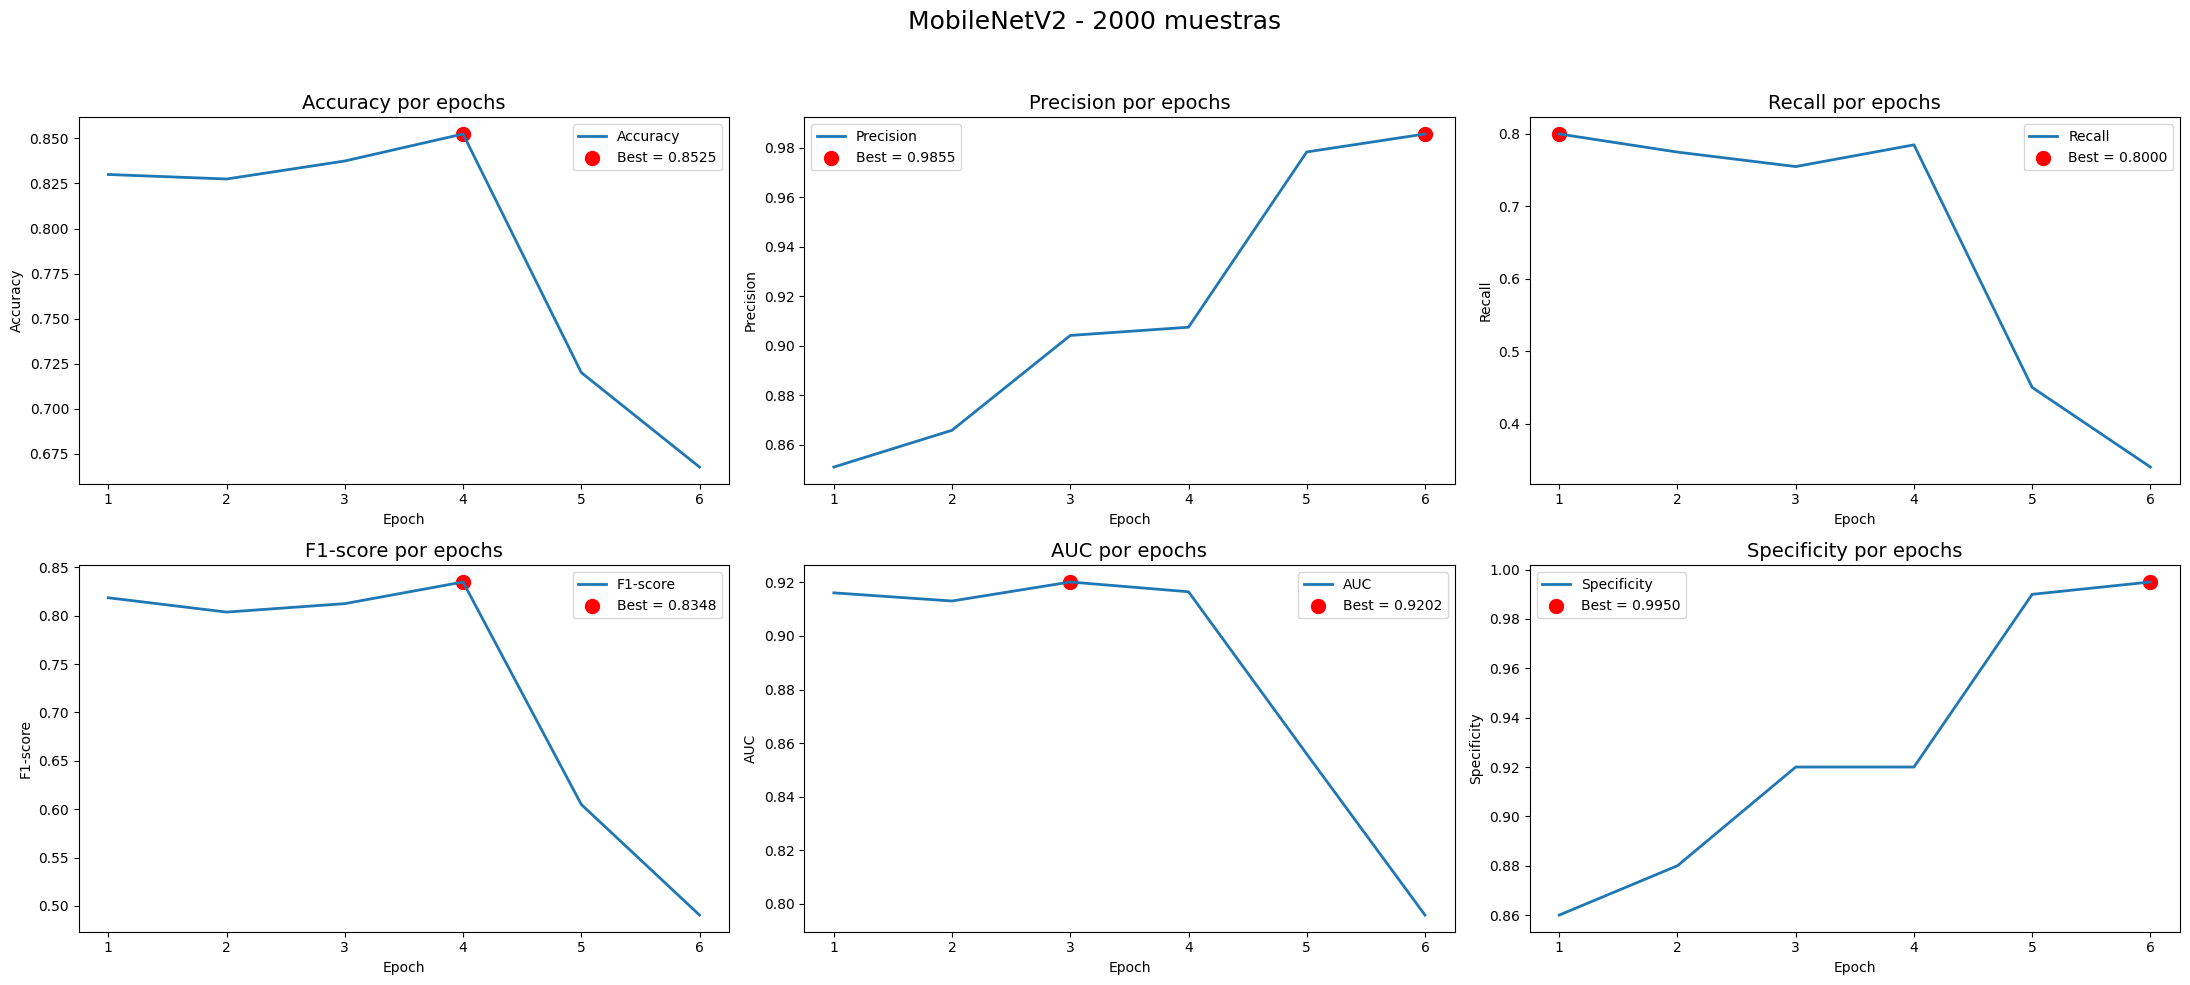

Gráfico guardado en: /content/drive/MyDrive/TFM/plots/metrics_MobileNetV2__3000_muestras.png


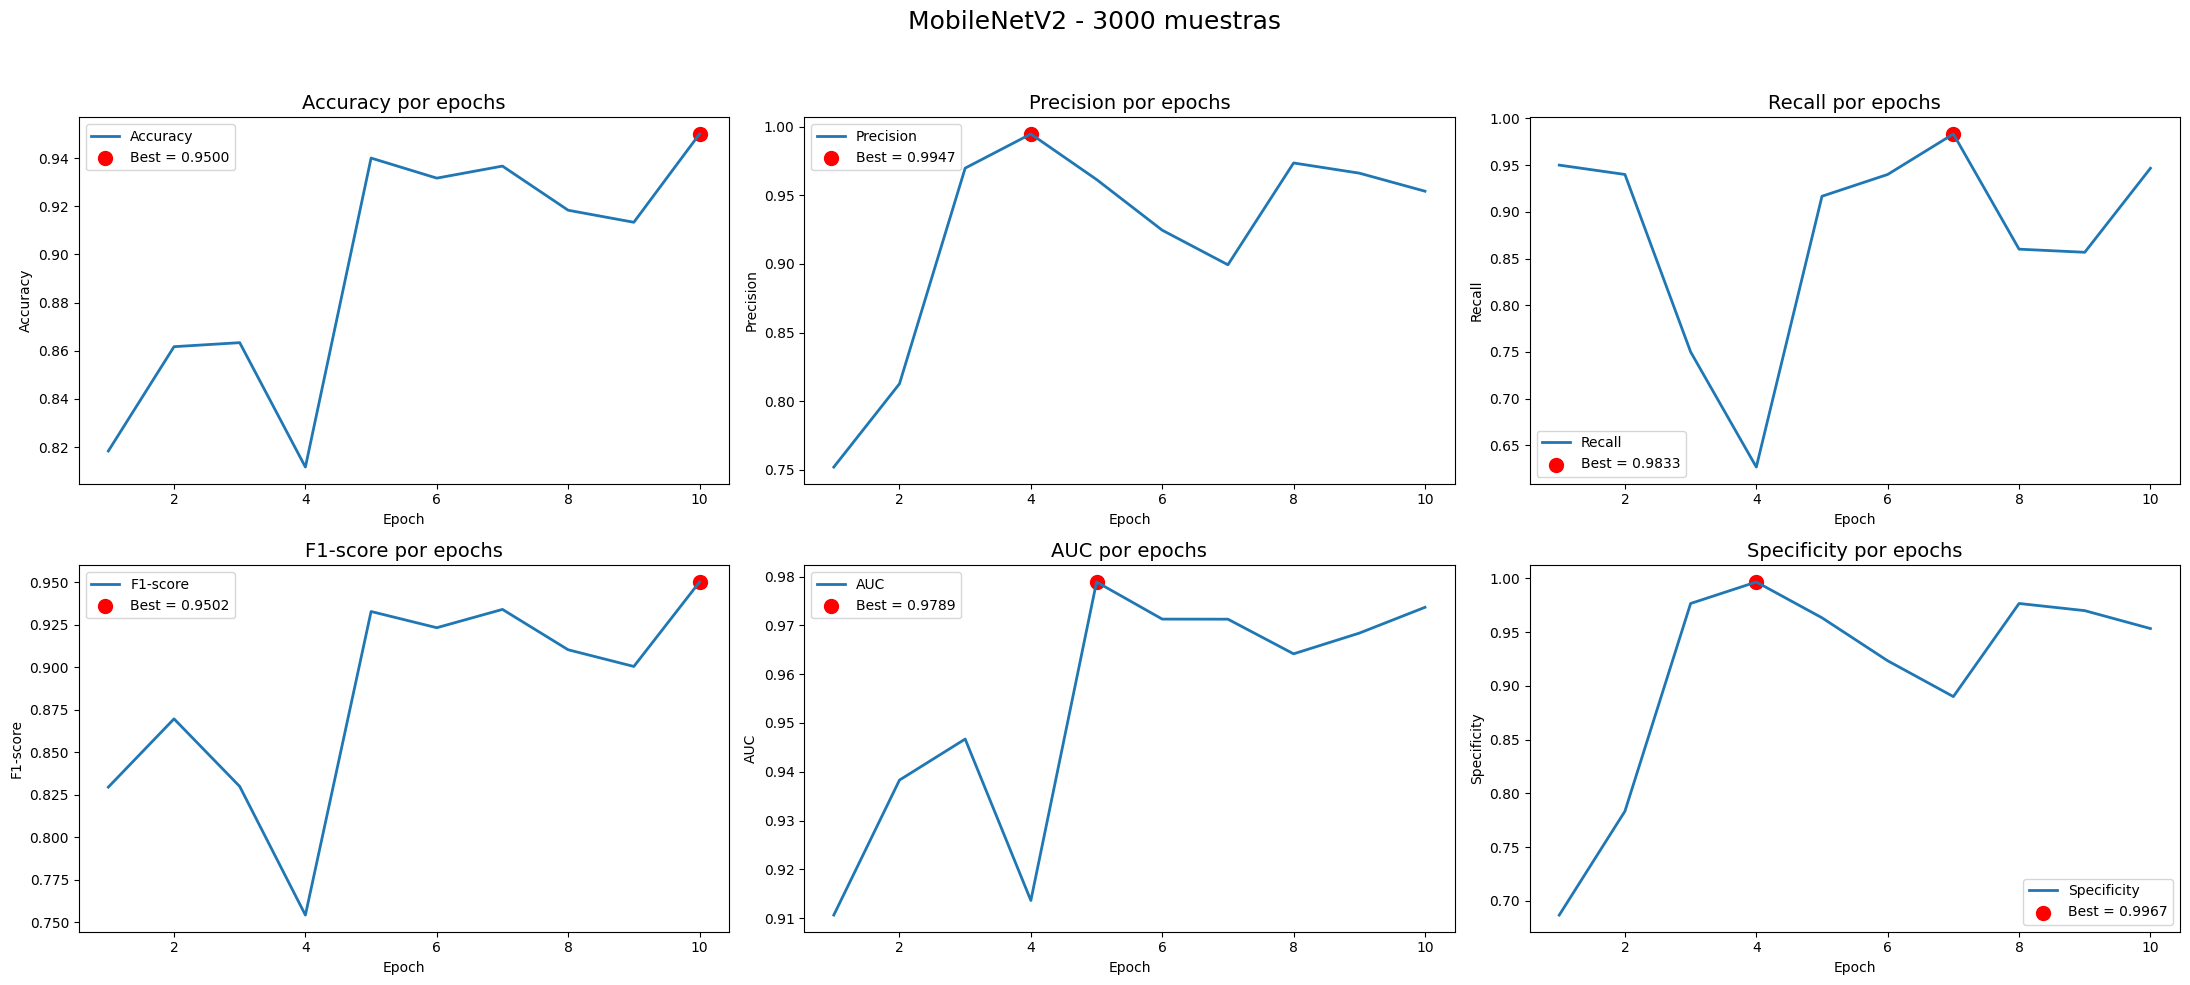

In [ ]:
for name, history in histories.items():
    plot_metrics(history, title_prefix=f'MobileNetV2 - {name} muestras')

# **Evaluación y predicción**


Evaluando modelo con 3000 muestras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Pesos cargados: /content/drive/MyDrive/TFM/models/MobileNetV2/model_best_3000.weights.h5
Accuracy:     0.9681
Precision:    0.9697
Recall:       0.9412
Specificity:  0.9833
F1-score:     0.9559
AUC:          0.9748
Loss:         0.2349

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9672    0.9833    0.9752       120
   Malignant     0.9697    0.9412    0.9552        68

    accuracy                         0.9681       188
   macro avg     0.9685    0.9623    0.9652       188
weighted avg     0.9681    0.9681    0.9680       188

 Matriz de confusión guardada: /content/drive/MyDrive/TFM/plots/evaluation/MobileNetV2/confusion_matrix_3000.png


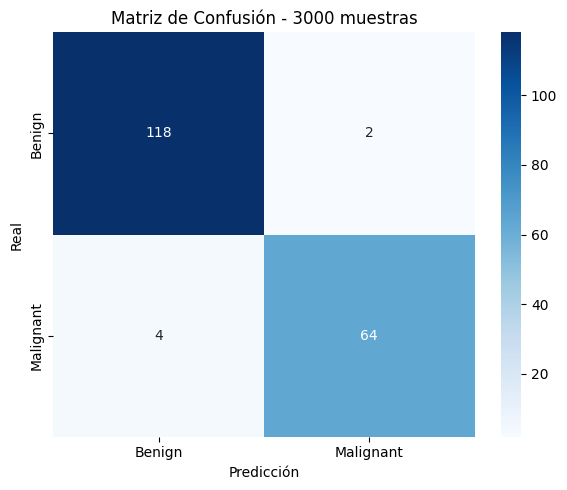

 Curva ROC guardada: /content/drive/MyDrive/TFM/plots/evaluation/MobileNetV2/roc_curve_3000.png


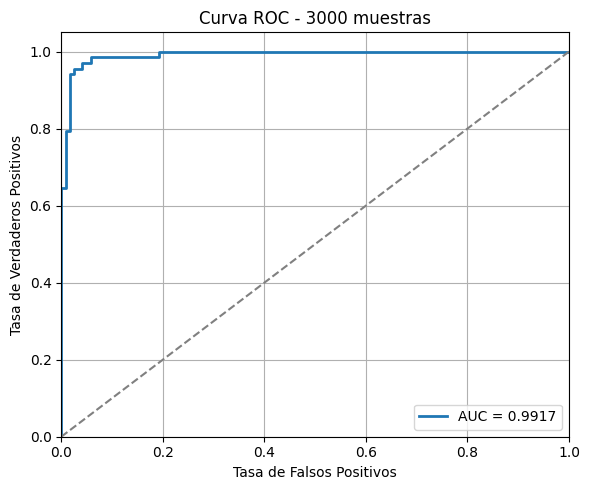

In [ ]:
# Ruta donde guardar las figuras
eval_plot_dir = '/content/drive/MyDrive/TFM/plots/evaluation/MobileNetV2'
os.makedirs(eval_plot_dir, exist_ok=True)

# Diccionario para guardar evaluaciones
evaluations = {}

# Evaluamos modelo con 3000 muestras
name = "3000"
print(f"\nEvaluando modelo con {name} muestras")

# Cargamos pesos
model_path = f"/content/drive/MyDrive/TFM/models/MobileNetV2/model_best_{name}.weights.h5"
mobilenet_model.load_weights(model_path)
print(f" Pesos cargados: {model_path}")


# Evaluamos
evaluation_metrics = mobilenet_model.evaluate(test_gen, verbose=0, return_dict=True)
evaluations[name] = evaluation_metrics

# Mostramos métricas
print(f"Accuracy:     {evaluation_metrics.get('accuracy', 0):.4f}")
print(f"Precision:    {evaluation_metrics.get('precision', 0):.4f}")
print(f"Recall:       {evaluation_metrics.get('recall', 0):.4f}")
print(f"Specificity:  {evaluation_metrics.get('specificity', 0):.4f}")
print(f"F1-score:     {evaluation_metrics.get('F1 score', 0):.4f}")
print(f"AUC:          {evaluation_metrics.get('auc', 0):.4f}")
print(f"Loss:         {evaluation_metrics.get('loss', 0):.4f}")

# Predicciones
test_gen.reset()
y_pred_probs = mobilenet_model.predict(test_gen, verbose=0).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_gen.classes

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=["Benign", "Malignant"],
    digits=4
))

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.title(f'Matriz de Confusión - {name} muestras')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
conf_path = os.path.join(eval_plot_dir, f"confusion_matrix_{name}.png")
plt.savefig(conf_path)
print(f" Matriz de confusión guardada: {conf_path}")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title(f'Curva ROC - {name} muestras')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
roc_path = os.path.join(eval_plot_dir, f"roc_curve_{name}.png")
plt.savefig(roc_path)
print(f" Curva ROC guardada: {roc_path}")
plt.show()

# **Grad-CAM**

19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


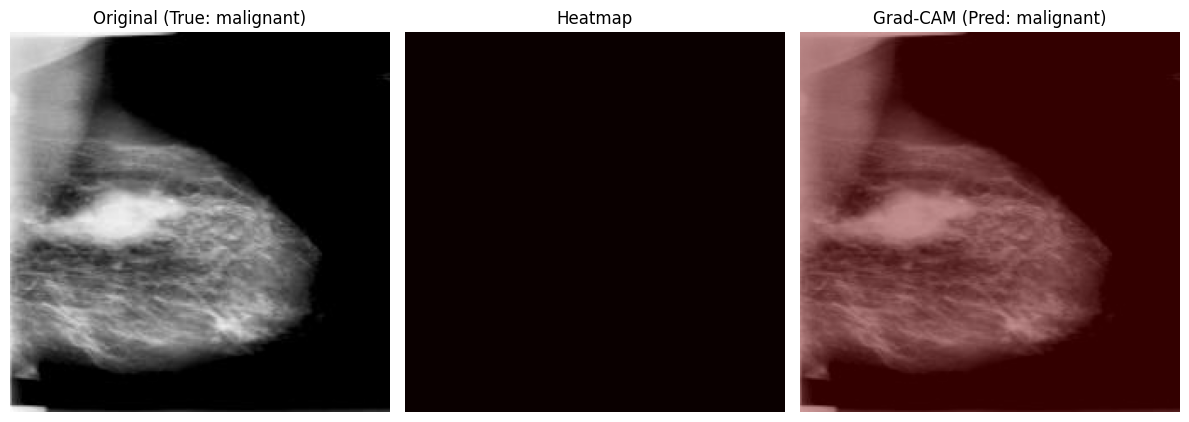

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_correct_malignant_0.png


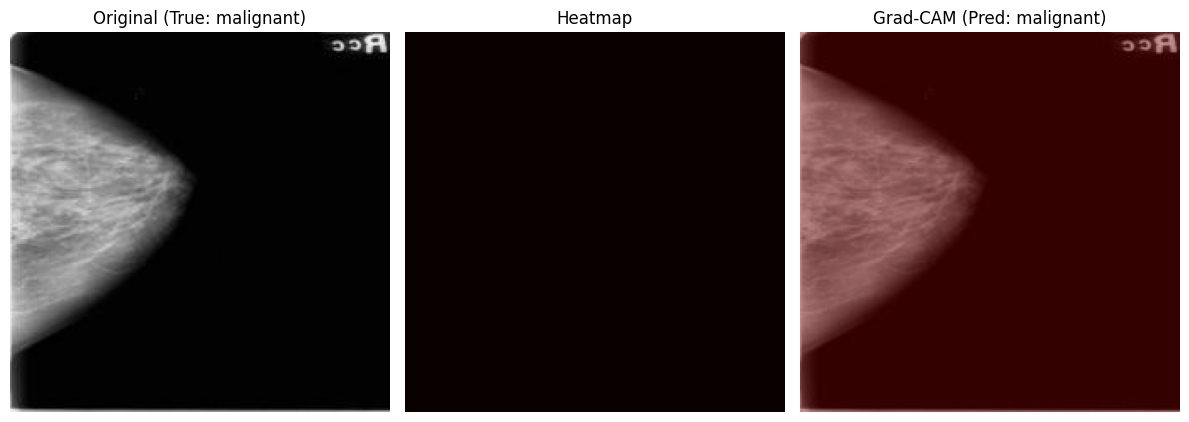

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_correct_malignant_1.png


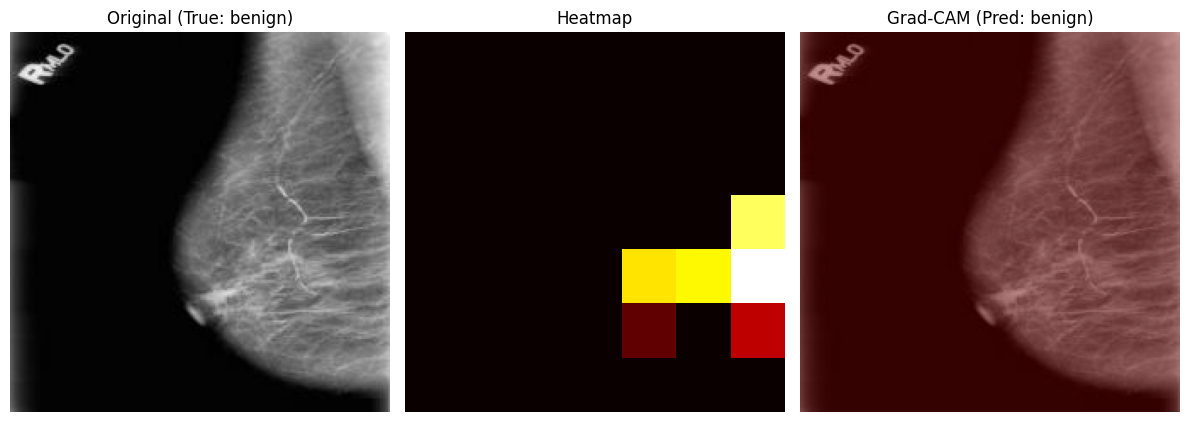

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_correct_benign_2.png


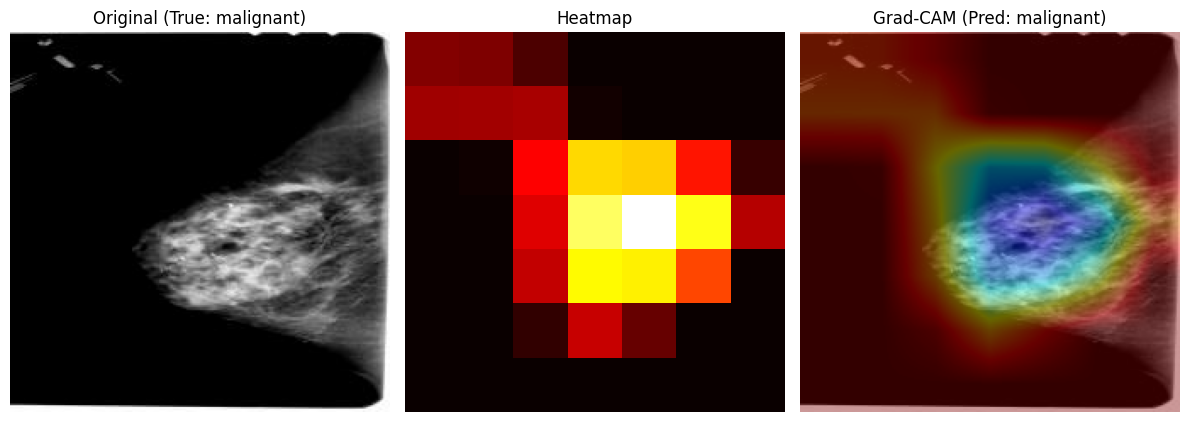

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_correct_malignant_3.png


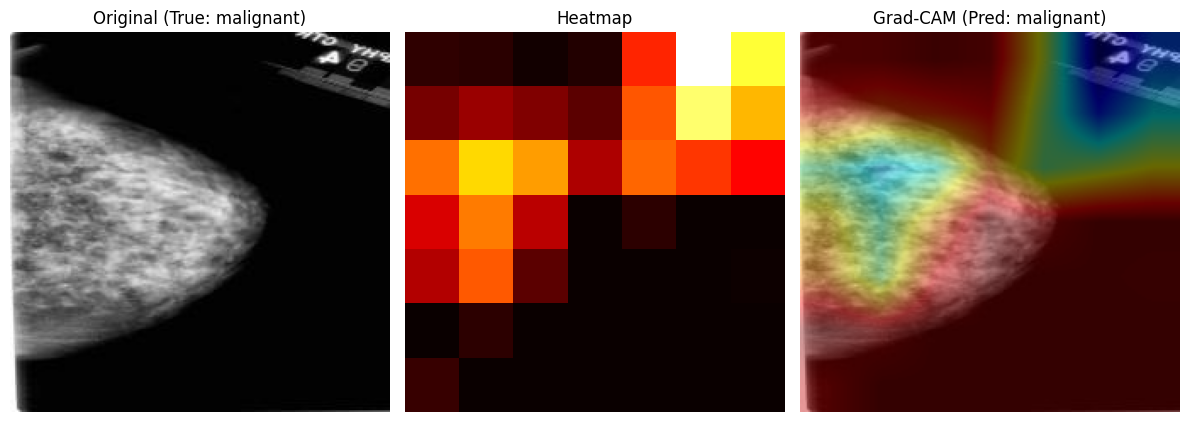

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_correct_malignant_5.png


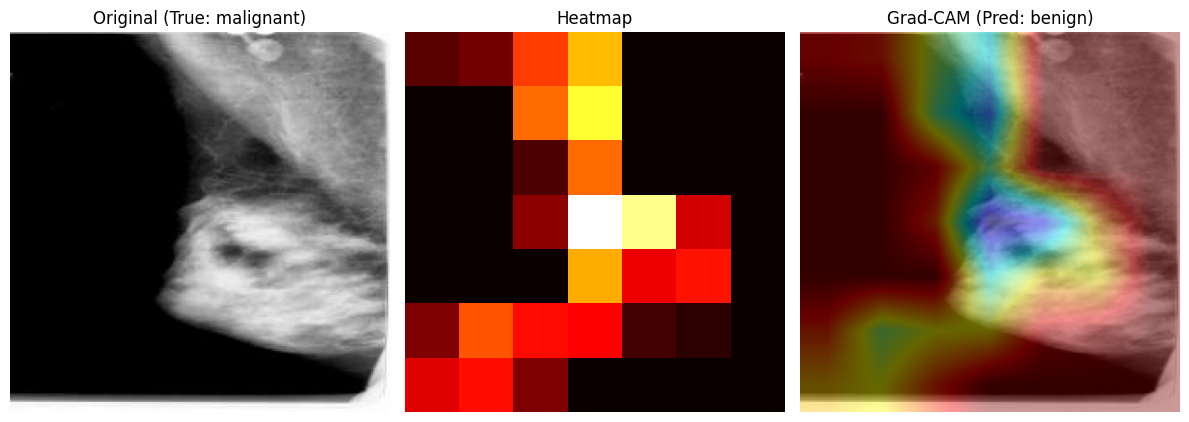

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_wrong_malignant_4.png


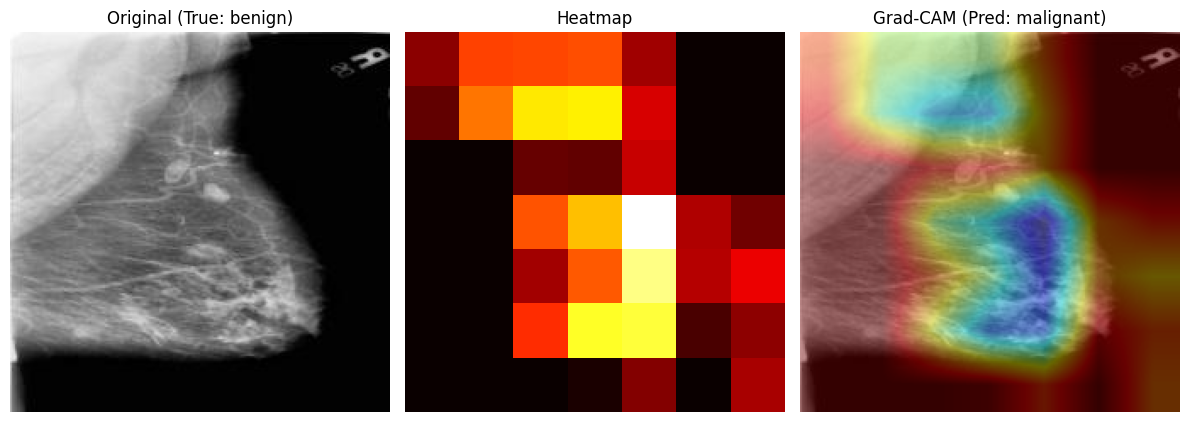

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_wrong_benign_7.png


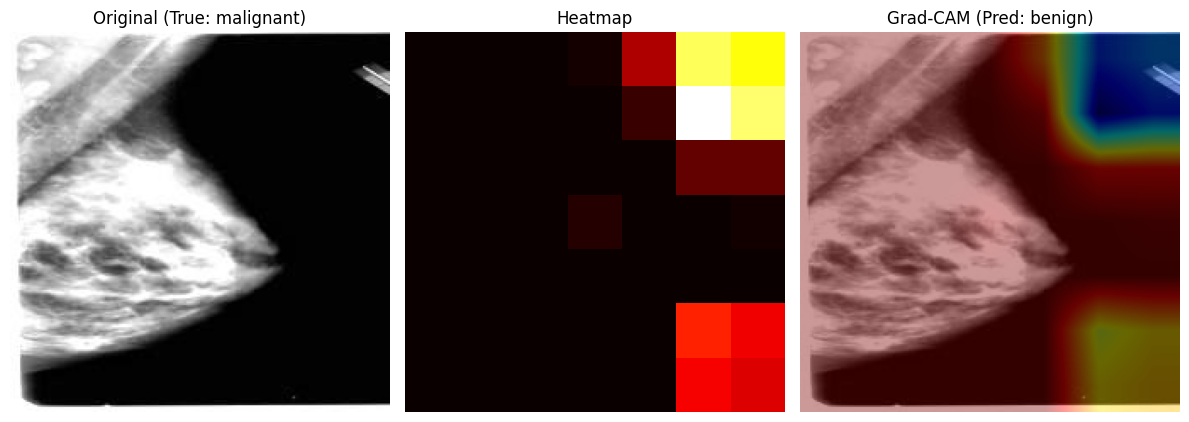

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_wrong_malignant_28.png


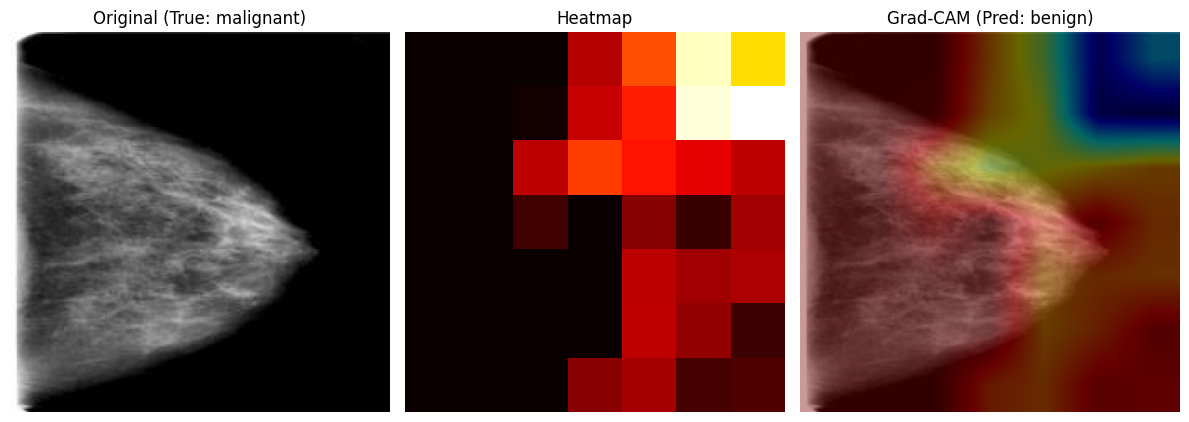

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_wrong_malignant_102.png


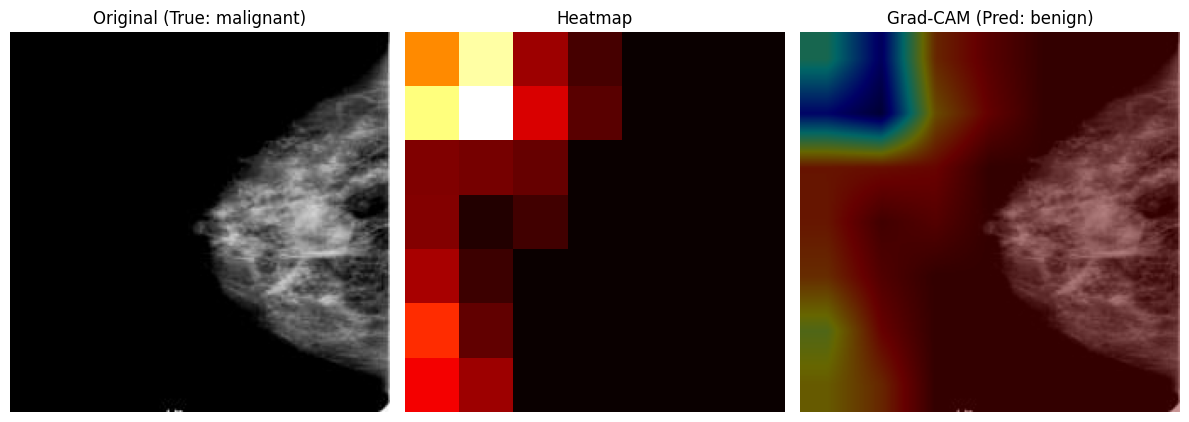

Guardado: /content/drive/MyDrive/TFM/gradcam_mobilenet/gradcam_wrong_malignant_105.png


In [ ]:
# Cargamos modelo
model_path = f"/content/drive/MyDrive/TFM/models/MobileNetV2/model_best_{name}.weights.h5"
mobilenet_model.load_weights(model_path)

# Última capa convolucional usada para Grad-CAM
last_conv_layer_name = "Conv_1"

# Función Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

# Superponemos heatmap sobre imagen
def overlay_gradcam(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed

# Directorio de salida
output_dir = "/content/drive/MyDrive/TFM/gradcam_mobilenet"
os.makedirs(output_dir, exist_ok=True)

# Obtenemos datos del generador
test_gen.reset()
x_data, y_data = [], []

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    x_data.append(x_batch)
    y_data.append(y_batch)

x_data = np.concatenate(x_data)
y_data = np.concatenate(y_data)

# Realizamos predicciones
y_pred_probs = mobilenet_model.predict(x_data)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = y_data.astype(int).flatten()

# Índices de predicciones correctas e incorrectas
correct_indices = np.where(y_pred == y_true)[0][:5]
incorrect_indices = np.where(y_pred != y_true)[0][:5]
selected_indices = list(correct_indices) + list(incorrect_indices)

# Aplicamos Grad-CAM y guardamos imágenes
for idx in selected_indices:
    img = x_data[idx]
    true_label = int(y_true[idx])
    pred_label = int(y_pred[idx])
    correct = "correct" if true_label == pred_label else "wrong"
    label_name = "benign" if true_label == 0 else "malignant"

    img_array = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_array, mobilenet_model, last_conv_layer_name)

    img_uint8 = np.uint8(img * 255)
    overlayed_img = overlay_gradcam(img_uint8, heatmap)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_uint8)
    plt.title(f"Original (True: {label_name})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title("Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_img)
    pred_label_name = "benign" if pred_label == 0 else "malignant"
    plt.title(f"Grad-CAM (Pred: {pred_label_name})")
    plt.axis('off')
    plt.tight_layout()

    output_path = os.path.join(output_dir, f"gradcam_{correct}_{label_name}_{idx}.png")
    cv2.imwrite(output_path, cv2.cvtColor(overlayed_img, cv2.COLOR_RGB2BGR))
    plt.show()

    print(f"Guardado: {output_path}")